# Nigerian Housing Rental Analysis

The assumption is that we work for a online agent that does house reccommendation service for customers searching for properties to rent but are limited by some constraints or some kind of preference.  The company is interested in  getting insights into the scraped data that have been cleaned.

They need us to use the data given to answer the following questions:
1. which of the states should the company recommend to customers who are interested in cheap to moderately priced rents (between 50,000 - 1,000,000 naira)?
2. With the first question answered, which city are houses more available for rent?
3. dividing states according to country zones, where are average rent prices the highest and lowest?
4. Which zones should we recommend to luxury tennants (those willing to pay above 10,000,000 naira)?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
housing_data = pd.read_csv("combined_housing_cleaned.csv")

In [3]:
housing_data.head()

,Unnamed: 0,price_naira,unit,city_location,bedrooms,baths,state
0,0,33000000.0,Per Year,badagry express way,Unknown,5,lagos
1,1,30000000.0,Per Year,badagry express way,Unknown,7,lagos
2,2,40000000.0,Per Year,badagry express way,Unknown,5,lagos
3,3,5500000.0,Per Year,nigeria,Unknown,4,lagos
4,4,48000000.0,Per Year,lagos,Unknown,3,lagos


In [4]:
housing_data["price_naira"].describe()

count    8.179000e+03
mean     7.910593e+07
std      4.445914e+09
min      5.500000e+04
25%      5.900000e+05
50%      1.600000e+06
75%      4.000000e+06
max      4.000000e+11
Name: price_naira, dtype: float64

The description shows that the average price is about 8million Naira while the maximum is 400 Billion Naira.  There seems to be something wrong with this because the maximum price is too high above the average. To investigate this, a scatter plot is used to show the variations in price more clearly.

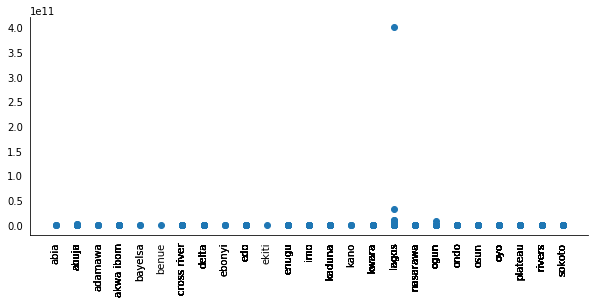

In [5]:
fig,ax=plt.subplots(figsize=(10,4))
ax.scatter(x=housing_data["state"], y = housing_data["price_naira"])
ax.tick_params(bottom = False, left = False, right = False, top =False)
ax.set_xticks(housing_data["state"])
ax.set_xticklabels(housing_data["state"], rotation=90,fontweight="light")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show();

The plot shows there is a price that belongs to lagos state that is far above every other in the dataset and it corresponds to the maximum price we saw earlier. Since this price seems unreasonable for a yeearly rent, it will affect our analysis. Thus we decide to drop any row whose price is above 1 billion naira

In [6]:
housing_data = housing_data[housing_data["price_naira"].between(50000,1000000000)]

To answer the first question we:
1. create a label such that houses between 50,000 - 200,000 are labelled "cheap", those between 200,000 - 1million naira are labelled moderate, those within 1million - 10million are ranged "premium" and above 10million labelled "luxury".
2. create a new dataset for cheap and moderate housing.
3. Analysing the states by the ranks.

First we create a function for the labelling

In [7]:
def house_rank(value):
    if 50000 < value <= 200000:
        return "cheap"
    elif 200000< value <=1000000:
        return "moderate"
    elif 1000000 <value <=10000000:
        return "premium"
    else:
        return "luxury"

we apply the function to  the price_naira column and store the output in a new column named "house_ranks". We create a crosstab table showing states by house_ranks counts.

In [8]:
housing_data["house_ranks"] = housing_data["price_naira"].apply(house_rank)

In [9]:
housing_data["house_ranks"].value_counts(dropna=False)

premium     3934
moderate    2790
luxury       891
cheap        530
Name: house_ranks, dtype: int64

Some states in the dataset have insignificant amount of data. We filter out states whose rows are less than 10. This will make our visualization less clustered and more appealing. We then go ahead to create a table of states with the ratio of the types of house_ranks in each state.

In [10]:
big_states = housing_data.groupby("state").filter(lambda x : len(x) >10)

In [11]:
state_ranks =pd.crosstab(index=big_states ['state'], columns=big_states ['house_ranks'], normalize='index').reset_index().set_index("state")

In [12]:
state_ranks.rename(columns ={"cheap" :"ratio_cheap", "luxury": "ratio_luxury","moderate":"ratio_moderate", "premium":"ratio_premium"}, inplace=True)

In [13]:
state_ranks

house_ranks,ratio_cheap,ratio_luxury,ratio_moderate,ratio_premium
state,,,,
abuja,0.019457,0.118100,0.160181,0.702262
cross river,0.058824,0.058824,0.529412,0.352941
delta,0.076923,0.153846,0.538462,0.230769
edo,0.240000,0.040000,0.600000,0.120000
enugu,0.040000,0.040000,0.640000,0.280000
imo,0.000000,0.000000,0.809524,0.190476
kaduna,0.051282,0.025641,0.256410,0.666667
kwara,0.012245,0.036735,0.395918,0.555102
lagos,0.066701,0.149757,0.313826,0.469716


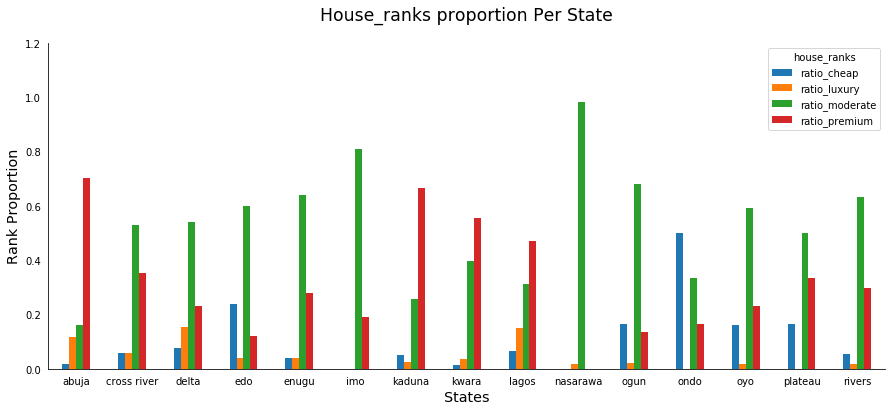

In [14]:
ax = state_ranks.plot(kind ="bar",rot=0, figsize=(15,6), fontsize=10, width=0.5)
ax.set_xlabel("States", fontsize="x-large")
ax.set_ylabel("Rank Proportion", fontsize="x-large")
ax.set_title("House_ranks proportion Per State", fontsize="xx-large").set_position([.5, 1.05])
ax.tick_params(bottom=False, top=False, left=False, right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0,1.2)
plt.show()

This initital analysis compares the ratio of the type of houses present in each state. 
Based on the result, it appears that the Ondo state has more cheap houses for rent more than any other state while Nasarawa state has more or moderately prices rents compared to the rest states.

## What Towns are cheap  Houses for Rent More?

We first extract data of just Ondo state and find out the top 5 locations where cheap houses can be found.

In [15]:
ondo_cities = housing_data[housing_data["state"]=="ondo"].groupby("house_ranks")

In [16]:
cheap_houses = ondo_cities.get_group("cheap").sort_values("price_naira")

In [17]:
cheap_houses["city_location"].value_counts()

akure    6
Name: city_location, dtype: int64

The City of Akure has the cheapest houses. In fact, it is the only location where houses are classed cheap. We show the percentages of the type of houses in this city visually using a pie chart.

In [18]:
ondo  = housing_data[housing_data["state"]=="ondo"]

In [19]:
akure  = housing_data[housing_data["city_location"]=="akure"]

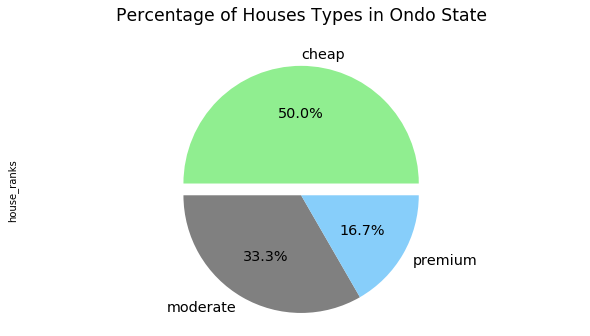

In [20]:
ax = akure["house_ranks"].value_counts().plot.pie(explode=(0.1,0,0),autopct='%1.1f%%', colors =['lightgreen', 'grey', 'lightskyblue'], fontsize = "x-large", figsize =(10,5))
plt.axis('equal')
ax.set_title("Percentage of Houses Types in Ondo State", fontsize = "xx-large").set_position([.5, 1.1])
plt.show();                                  

### We now do same for Moderately priced. In this case, Nasarawa state

In [21]:
nasarawa_cities = housing_data[housing_data["state"]=="nasarawa"].groupby("house_ranks")

In [22]:
moderate_houses = nasarawa_cities.get_group("moderate")

In [23]:
top_cities = round(moderate_houses.groupby("city_location")["price_naira"].mean().sort_values(ascending = False), 0)

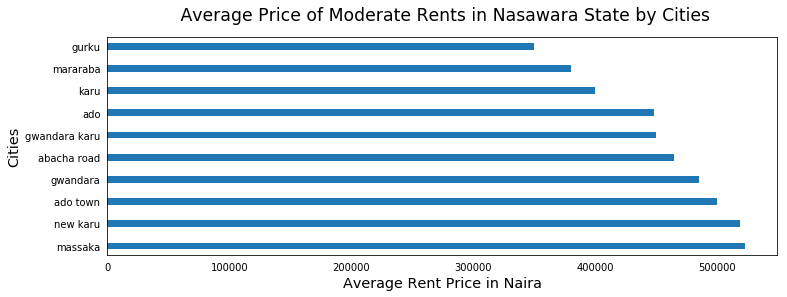

In [24]:
ax = top_cities.plot(kind="barh", figsize= (12,4), width = .3)
ax.set_title(" Average Price of Moderate Rents in Nasawara State by Cities", fontsize= "xx-large").set_position([.5, 1.05])
ax.tick_params(bottom =False, left = False, right= False, top =False)
ax.set_ylabel("Cities", fontsize= "x-large")
ax.set_xlabel("Average Rent Price in Naira", fontsize ="x-large")
plt.show();

# Analysing by Zones

First, we check the unique states in the dataset and divide them according to the Geopolitical zones in the country. Next, a function  is created to scan through the state column and return the appropriate zone the state belongs to. The output is stored into a new column called zones.

In [25]:
housing_data["state"].unique()

array(['lagos', 'abuja', 'ogun', 'oyo', 'delta', 'rivers', 'cross river',
       'enugu', 'kaduna', 'imo', 'ebonyi', 'kano', 'nasarawa', 'kwara',
       'edo', 'benue', 'bayelsa', 'adamawa', 'akwa ibom', 'abia', 'ekiti',
       'osun', 'ondo', 'sokoto', 'plateau'], dtype=object)

In [26]:
North_central = ['nasarawa','abuja','kwara','benue','plateau']
North_east = ['adamawa']
North_west = ['kaduna','kano','sokoto']
South_south = ['rivers','edo','bayelsa','delta','akwa ibom','cross river']
South_east = ['enugu','imo','ebonyi','abia']
South_west= ['lagos','ogun','oyo','ekiti','osun','ondo']


def zoning(state):
    if state in North_central:
        return "north_central"
    elif state in North_east:
        return "north_east"
    elif state in North_west:
        return "north_west"
    elif state in South_south:
        return "south_south"
    elif state in South_east:
        return "south_east"
    elif state in South_west:
        return "south_west"

In [27]:
housing_data["zones"] = housing_data["state"].apply(zoning)

To get the grouped dataset, we alpply the filter function to the groupby object

In [28]:
nig_zone = housing_data.groupby("zones").filter(lambda x: len(x) >0)

In [29]:
zone_table = pd.crosstab(index = nig_zone ["zones"], columns = nig_zone ["house_ranks"], normalize = "index").reset_index().set_index("zones")

In [30]:
zone_table.rename(columns ={"cheap" :"ratio_cheap", "luxury": "ratio_luxury","moderate":"ratio_moderate", "premium":"ratio_premium"}, inplace=True)

In [31]:
zone_table

house_ranks,ratio_cheap,ratio_luxury,ratio_moderate,ratio_premium
zones,,,,
north_central,0.019048,0.107540,0.201587,0.671825
north_east,0.000000,0.000000,0.500000,0.500000
north_west,0.057692,0.038462,0.269231,0.634615
south_east,0.076923,0.019231,0.653846,0.250000
south_south,0.068762,0.021611,0.614931,0.294695
south_west,0.087859,0.121006,0.383187,0.407947


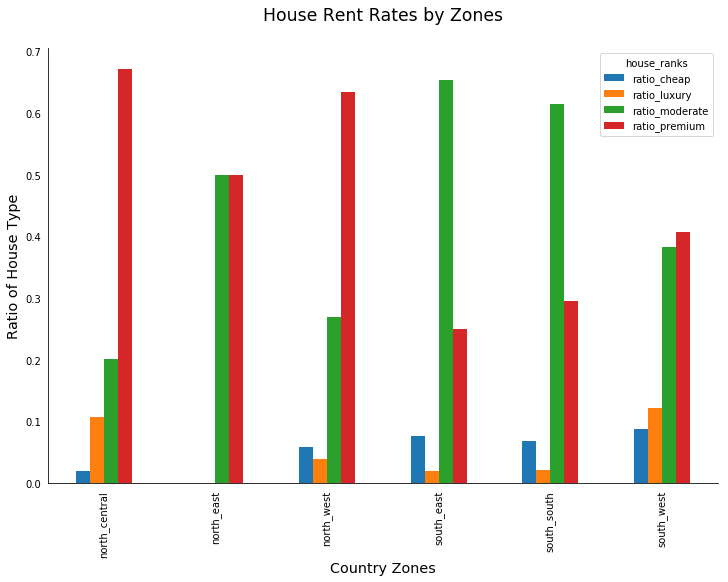

In [33]:
ax =zone_table.plot(kind ="bar", figsize =(12,8))
ax.tick_params(bottom=False, top=False, left=False, right=False)
ax.set_title("House Rent Rates by Zones", fontsize= "xx-large").set_position([.5, 1.05])
ax.set_xlabel("Country Zones", fontsize = "x-large")
ax.set_ylabel("Ratio of House Type", fontsize = "x-large")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show();

The zones for the most common house type can be deduced from the plot as follows:
1. Cheap house rent zone : South_west
2. Moderate house rent zone : South_east
3. Premium house rent zone : North_central
4. Luxury house rent zone : South_west

The chart reveals that the ratio of luxury houses are more in the south-west followed by north-central zones. Since it's easier for the firm to access more luxury houses for rent there, they should recommend these locations to those willing to pay above 10million rent per year